In [ ]:
!apt install subversion
!svn checkout https://github.com/mahasiswateladan/myo-project/trunk/dataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2 subversion
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,355 kB of archives.
After this operation, 10.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libapr1 amd64 1.6.5-1ubuntu1 [91.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libaprutil1 amd64 1.6.1-4ubuntu2.1 [84.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libserf-1-1 amd64 1.3.9-8build1 [45.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libutf8proc2 amd64 2.5.0-1 [50.0 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from scipy.fft import fft, fftfreq
import scipy as sc
from scipy.signal import butter, lfilter, filtfilt, sosfiltfilt
import csv
from keras.utils import to_categorical

## Actual Process

In [ ]:
# high-pass Butterworth filter for envelope detection
def highpass_filter(signal, filter_order, sampling_freq, cutoff_freq_low, cutoff_freq_high):
    signal_filter = np.zeros((16000, 8))
    # signal_filter = []
    nyquist_freq = 254 * 0.5            # Nyquist theorem (the sampling rate should be at least twice the highest frequency component in the signal)
    normalized_lowcut = cutoff_freq_low / nyquist_freq
    normalized_highcut = cutoff_freq_high / nyquist_freq
    b, a = sc.signal.butter(filter_order, [normalized_lowcut, normalized_highcut], btype='bandpass', analog=False)

    for ch in range(8):
        filter = filtfilt(b, a, signal[:, ch])    
        # signal_filter.append(filter)  
        signal_filter[:, ch] = filter
        
    # print(np.shape(signal_filter))
    return signal_filter


def sliding_windows(data, window_size):
    window_step = int(window_size * 0.1)

    num_windows = int((len(data) - window_size) / window_step) + 1
    windows = np.ndarray((num_windows, window_size, 8))

    for i in range(num_windows):
        start = i * window_step
        windows[i] = data[start:start+window_size]
    
    return windows

In [ ]:
def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = int((valid) // ss)
    # print(nw, ws)
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = int(i * ss)
        stop = int(start + ws)
        out[i] = a[start:stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()
    # print(X)
    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64, compute_onesided=True):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=compute_onesided)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold

        specgram[np.isnan(specgram)] = -thresh
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram

In [ ]:
path1 = "dataset/Raw2"
path2 = "dataset/Raw4"
# path = [path1, path2]
path = [path2]
# path = "dataset/Processed"

train_subjects1 = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
train_subjects2 = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11']
# train_subjects = [train_subjects1, train_subjects2]
train_subjects = [train_subjects2]

channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']

In [ ]:
max = []
count =  0

for subject in train_subjects2:
    gesture_list = os.path.join(path1, subject)
    gesture_dirlist = os.listdir(gesture_list)
    
    for gesture in gesture_dirlist:
        df = pd.read_csv(os.path.join(gesture_list, gesture))
        data = np.array(df.iloc[:, 1:9])
        # print(f'Sample: {gesture}, Size: {data.shape}')

        max.append(data.shape[0])
        count = count + 1

print(f'Total Sample: {len(max)}, Avg: {int(np.max(max))}')

Total Sample: 440, Avg: 47303


In [ ]:
# Read all RAW EMG data for Train
windows_seq = 791
sample_len = 16000
window_size = 200
# X_1 = np.zeros((520, windows_seq, window_size, 8))        # Both dataset
X_1 = np.zeros((220, windows_seq, window_size, 8))
train_label = []
i = 0

for index in range(1):
    for subject in train_subjects[index]:
        gesture_list = os.path.join(path[index], subject)
        gesture_dirlist = os.listdir(gesture_list)
        
        for gesture in gesture_dirlist:
            if("null" in gesture):
                pass
            else:
                df = pd.read_csv(os.path.join(gesture_list, gesture))
                if len(df.T) > 8:
                    data = np.array(df.iloc[:, 1:9])
                else:
                    data = np.array(df)

                # Pad or Cut
                train_signal = np.zeros((sample_len, 8))
                if data.shape[0] > sample_len:
                    train_signal[:sample_len, :] = data[:sample_len, :]
                else:
                    train_signal[:data.shape[0], :] = data

                # Pre-processing
                ## 2/20, 4/10
                sampling_freq  = 200             # Nyquist theorem (the sampling rate should be at least twice the highest frequency component in the signal)
                filter_order = 5
                cutoff_freq_low  = 20
                cutoff_freq_high = 100
                signal_filter = highpass_filter(train_signal, filter_order, sampling_freq, cutoff_freq_low, cutoff_freq_high)            # Filter Signal Using High-pass Filter
                X_1[i, :, :, :] = sliding_windows(signal_filter, window_size)             # 1 second with 50%overlap

                # Label
                if("close" in gesture):
                    for j in range(windows_seq):
                        train_label.append(0)
                elif("open" in gesture):
                    for j in range(windows_seq):
                        train_label.append(1)
                elif("wavein" in gesture):
                    for j in range(windows_seq):
                        train_label.append(2)
                elif("waveout" in gesture):
                    for j in range(windows_seq):
                        train_label.append(3)
                else:
                    # for j in range(windows_seq):
                    #     train_label.append(4)
                    pass
                
                i = i + 1

# Reshape
X_train = np.reshape(X_1, (X_1.shape[0]*X_1.shape[1], X_1.shape[2], X_1.shape[3]))
X_train_copy = X_train
y_train = to_categorical(train_label)
y_train_copy = y_train
print(X_train.shape, y_train.shape)
print(f'Training Gesture 1: {sum(1 if x == 0 else 0 for x in train_label)}, Gesture 2: {sum(1 if x == 1 else 0 for x in train_label)}, Gesture 3: {sum(1 if x == 2 else 0 for x in train_label)}, Gesture 4: {sum(1 if x == 3 else 0 for x in train_label)}, No Gesture: {sum(1 if x == 4 else 0 for x in train_label)}')

(174020, 200, 8) (174020, 4)
Training Gesture 1: 43505, Gesture 2: 43505, Gesture 3: 43505, Gesture 4: 43505, No Gesture: 0


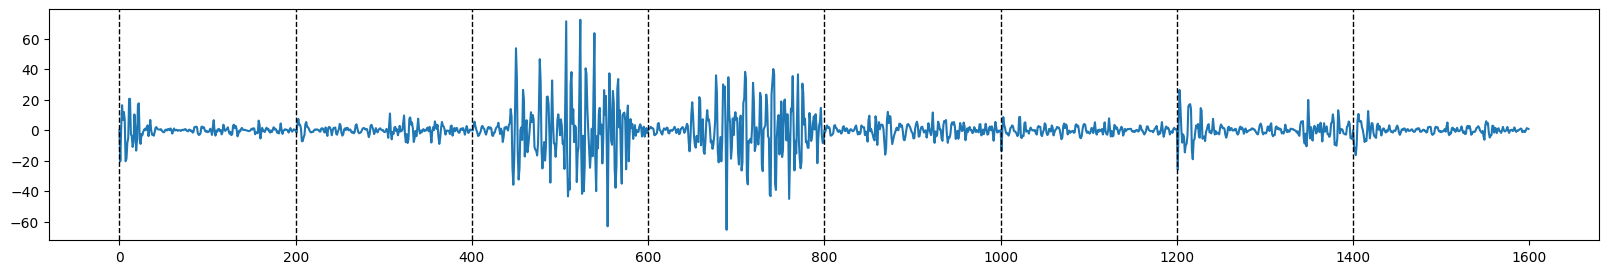

In [ ]:
ex = np.hstack((X_train_copy[0, :, 0], X_train_copy[0, :, 1], X_train_copy[0, :, 2], X_train_copy[0, :, 3], X_train_copy[0, :, 4], X_train_copy[0, :, 5], X_train_copy[0, :, 6], X_train_copy[0, :, 7]))
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(ex)
for n in range(0, len(ex), 200):
    plt.axvline(x=n, color='k', linewidth=1.0, linestyle='--')

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
print(tf.__version__)

2.12.0


### Rectification

(15, 240) -3.0 0.0


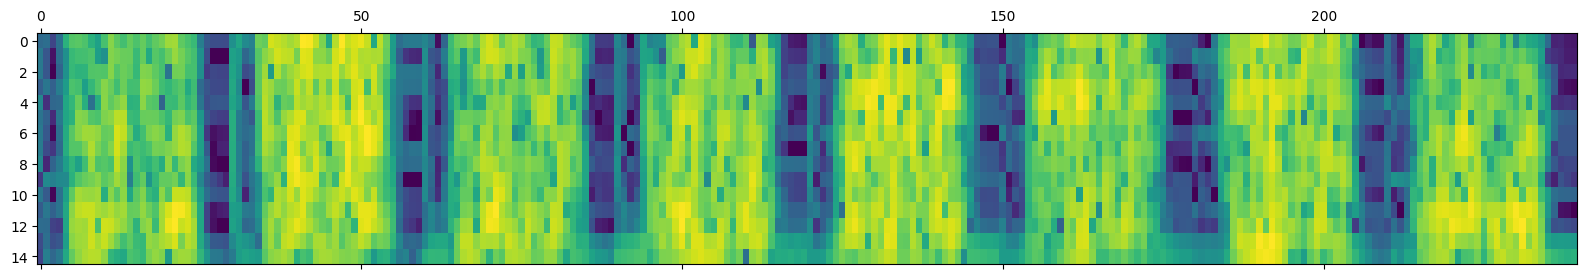

In [ ]:
fft_size = 60
step_size = fft_size - (0.80 * fft_size) # window size - (20% of window size)
thresh = 3

wav_spectrogram_1 = pretty_spectrogram(X_train_copy[0, :, 0], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_2 = pretty_spectrogram(X_train_copy[0, :, 1], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_3 = pretty_spectrogram(X_train_copy[0, :, 2], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_4 = pretty_spectrogram(X_train_copy[0, :, 3], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_5 = pretty_spectrogram(X_train_copy[0, :, 4], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_6 = pretty_spectrogram(X_train_copy[0, :, 5], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_7 = pretty_spectrogram(X_train_copy[0, :, 6], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
wav_spectrogram_8 = pretty_spectrogram(X_train_copy[0, :, 7], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)

wav_stack = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))
# wav_stack = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))
print(wav_stack.shape, wav_stack.min(),wav_stack.max())
ax=plt.axes()
ax.matshow(wav_stack)
ax.set_aspect(72/30)

<ipython-input-4-b4333a9548f1>:76: RuntimeWarning: divide by zero encountered in log10
  specgram = np.log10(specgram)  # take log


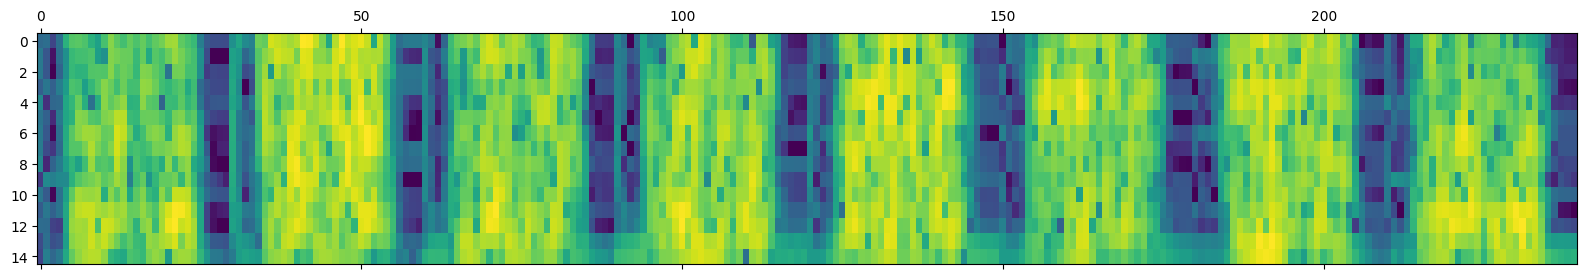

In [ ]:
train_data = np.zeros((X_train.shape[0], wav_stack.shape[0], wav_stack.shape[1]))
# fft_size = 80
# step_size = fft_size - (0.65 * fft_size) # window size - (20% of window size)
# thresh = 4


for i in range(X_train.shape[0]):
    # tmp = np.hstack((X_train[i, :, 0], X_train[i, :, 1], X_train[i, :, 2], X_train[i, :, 3], X_train[i, :, 4], X_train[i, :, 5], X_train[i, :, 6], X_train[i, :, 7]))
    # train_data[i,:,:] = pretty_spectrogram(tmp.flatten(), log=True, thresh=5, fft_size=200, step_size=15)
    wav_spectrogram_1 = pretty_spectrogram(X_train[i, :, 0], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_2 = pretty_spectrogram(X_train[i, :, 1], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_3 = pretty_spectrogram(X_train[i, :, 2], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_4 = pretty_spectrogram(X_train[i, :, 3], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_5 = pretty_spectrogram(X_train[i, :, 4], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_6 = pretty_spectrogram(X_train[i, :, 5], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_7 = pretty_spectrogram(X_train[i, :, 6], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)
    wav_spectrogram_8 = pretty_spectrogram(X_train[i, :, 7], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=True)

    train_data[i, :, :] = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))

ax=plt.axes()
ax.matshow(train_data[0, :, :])
ax.set_aspect(72/30)

In [ ]:
# Split into train and test sets (90% for training and 10% for testing)
X_train, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

# Split the remaining 90% into train and validation sets (50% for testing and 50% for validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(f'X_train: {np.shape(X_train)}, y_train: {np.shape(y_train)}, X_val: {np.shape(X_val)}, y_val: {np.shape(y_val)}, X_test: {np.shape(X_test)}, y_test: {np.shape(y_test)}')

# Normalize EMG dataset
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_val = (X_val-X_val.min())/(X_val.max()-X_val.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print((X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape), (X_train.min(),X_train.max()), (X_test.min(),X_test.max()), (X_val.min(),X_val.max()))

X_train: (189840, 15, 240), y_train: (189840, 4), X_val: (23730, 15, 240), y_val: (23730, 4), X_test: (23730, 15, 240), y_test: (23730, 4)
((189840, 15, 240), (189840, 4)) ((23730, 15, 240), (23730, 4)) ((23730, 15, 240), (23730, 4)) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0)


In [ ]:
# # GRU + Attention
# inp = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x = GRU(128, activation='tanh', return_sequences=True)(inp)
# x = MultiHeadAttention(num_heads=32, key_dim=64)(x, x, x)
# x = GRU(64, activation='tanh', return_sequences=True)(x)
# x = MultiHeadAttention(num_heads=16, key_dim=32)(x, x, x)
# x = GRU(32, activation='tanh')(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(4, activation='softmax')(x)
# model = Model(inp, x)

# GRU
inp = Input(shape=(X_train.shape[1],X_train.shape[2]))
x = GRU(128, activation='tanh', return_sequences=True)(inp)
x = GRU(64, activation='tanh', return_sequences=True)(x)
x = GRU(32, activation='tanh')(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)
model = Model(inp, x)

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 240)]         0         
                                                                 
 gru (GRU)                   (None, 15, 128)           142080    
                                                                 
 gru_1 (GRU)                 (None, 15, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 189,924
Trainable params: 189,924
Non-trainable

In [ ]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/1000
742/742 [==============================] - 18s 10ms/step - loss: 1.0757 - accuracy: 0.4967 - val_loss: 0.9061 - val_accuracy: 0.5852
Epoch 2/1000
742/742 [==============================] - 6s 8ms/step - loss: 0.8311 - accuracy: 0.6305 - val_loss: 0.8019 - val_accuracy: 0.6410
Epoch 3/1000
742/742 [==============================] - 6s 8ms/step - loss: 0.7446 - accuracy: 0.6747 - val_loss: 0.7250 - val_accuracy: 0.6908
Epoch 4/1000
742/742 [==============================] - 6s 8ms/step - loss: 0.6731 - accuracy: 0.7173 - val_loss: 0.6452 - val_accuracy: 0.7340
Epoch 5/1000
742/742 [==============================] - 6s 8ms/step - loss: 0.5738 - accuracy: 0.7722 - val_loss: 0.5321 - val_accuracy: 0.7913
Epoch 6/1000
742/742 [==============================] - 6s 8ms/step - loss: 0.4425 - accuracy: 0.8302 - val_loss: 0.4194 - val_accuracy: 0.8392
Epoch 7/1000
742/742 [==============================] - 6s 8ms/step - loss: 0.3511 - accuracy: 0.8666 - val_loss: 0.3408 - val_accurac

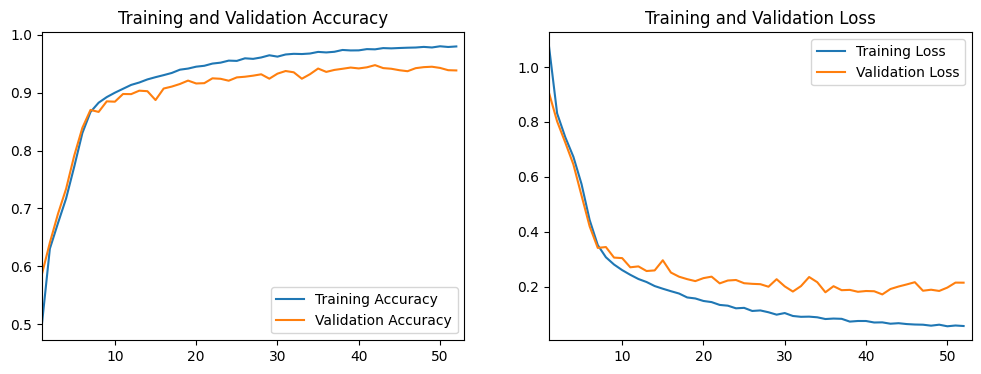

In [ ]:
# Plotting accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_acc)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
accuracy = accuracy * 100.0
print(accuracy)

186/186 [==============================] - 1s 4ms/step - loss: 0.1695 - accuracy: 0.9472
94.71976161003113


In [ ]:
# Calculate precision, recall, and F1-score

# Convert one-hot encoded labels to original format
y_true = np.argmax(y_test, axis=1)

# Convert predicted probabilities or labels to class labels
y_pred = np.argmax(model.predict(X_test), axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the calculated metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

742/742 [==============================] - 3s 3ms/step
Precision: 0.9477915947393535
Recall: 0.9471976401179941
F1-score: 0.9472751963904713


742/742 [==============================] - 2s 3ms/step


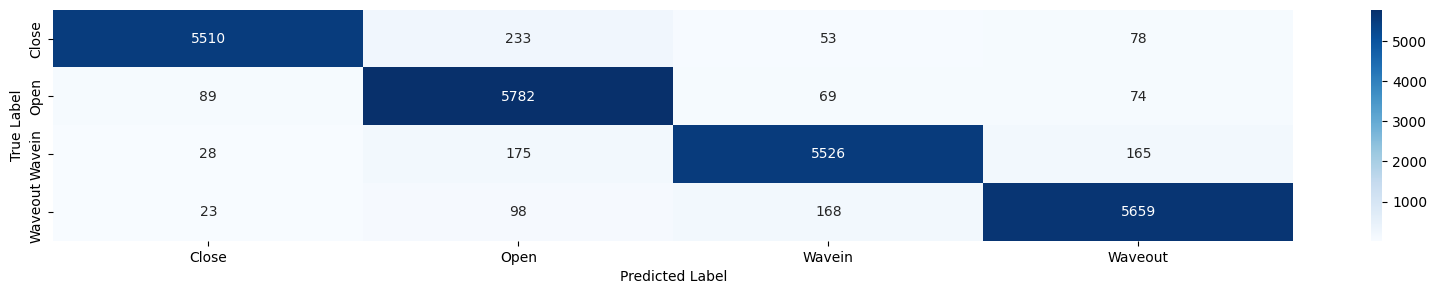

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)) 

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

# Create the heatmap with custom labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('True Label', fontsize = 10) # y-axis label with fontsize 15
# Show the plot
plt.show()

742/742 [==============================] - 2s 3ms/step


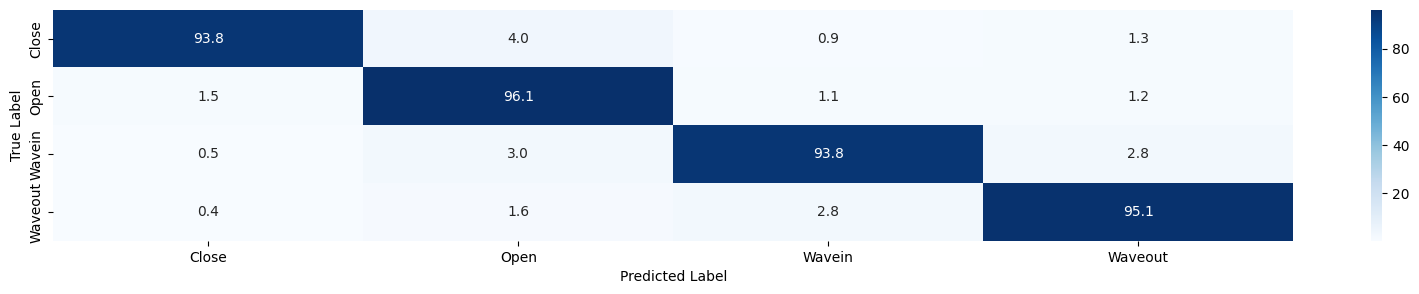

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Calculate the sum of predictions for each true label
sum_per_true_label = np.sum(cm, axis=1)

# Calculate the percentages
cm_percent = (cm / sum_per_true_label[:, np.newaxis]) * 100

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

# Create the heatmap with custom labels and percentage values
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.show()


### Test Unseen Dataset

In [ ]:
# input_data = pd.read_csv('dataset/Raw4/Test2/waveout/55.csv')
# input_data = np.array(input_data)
# ex = np.hstack((input_data[:, 0], input_data[:, 1], input_data[:, 2], input_data[:, 3], input_data[:, 4], input_data[:, 5], input_data[:, 6], input_data[:, 7]))
# plt.rcParams["figure.figsize"] = (20,3)
# plt.plot(ex)
# for n in range(0, len(ex), 200):
#     plt.axvline(x=n, color='k', linewidth=1.0, linestyle='--')

In [ ]:
path = "dataset/Raw4/Test2"
folder_dir = os.path.join(os.getcwd(), path)
dirlist = os.listdir(folder_dir)
print(dirlist)

['close', 'null', 'open', 'waveout', 'wavein']


In [ ]:
list_gesture = []
list_label = []

for gesture in dirlist:
    if("null" in gesture) or ".ipynb_checkpoints" in gesture:
        pass
    else: 
        gesture_list = os.path.join(path, gesture)
        gesture_dirlist = os.listdir(gesture_list)
        # print(gesture)
        
        true = 0
        false = 0
        for test_data in gesture_dirlist:
            # print(test_data)
            input_data = pd.read_csv(os.path.join(gesture_list, test_data))
            signal = np.array(input_data)

            if signal.shape[1] > 8:
                signal = np.array(input_data.iloc[:, 1:9])

            # Pad or Cut
            data = np.zeros((200, 8))
            if signal.shape[0] > 200:
                data[:200, :] = signal[:200, :]
            else:
                data[:signal.shape[0], :] = signal

            # Filter Signal Using High-pass Filter
            signal_filter = np.zeros((200, 8))
            nyquist_freq = 254 * 0.5            # Nyquist theorem (the sampling rate should be at least twice the highest frequency component in the signal)
            normalized_lowcut = 20 / nyquist_freq
            normalized_highcut = 100 / nyquist_freq
            b, a = sc.signal.butter(5, [normalized_lowcut, normalized_highcut], btype='bandpass', analog=False)

            for ch in range(8):
                filter = filtfilt(b, a, data[:, ch])  
                signal_filter[:, ch] = filter

            # Extract Feature
            feature = np.zeros((1, wav_stack.shape[0], wav_stack.shape[1]))
            # fft_size = 60
            # step_size = fft_size - (0.75 * fft_size) # window size - (20% of window size)
            # thresh = 3
            compute_onesided = True

            for i in range(1):
                wav_spectrogram_1 = pretty_spectrogram(signal_filter[:, 0], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_2 = pretty_spectrogram(signal_filter[:, 1], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_3 = pretty_spectrogram(signal_filter[:, 2], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_4 = pretty_spectrogram(signal_filter[:, 3], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_5 = pretty_spectrogram(signal_filter[:, 4], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_6 = pretty_spectrogram(signal_filter[:, 5], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_7 = pretty_spectrogram(signal_filter[:, 6], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_8 = pretty_spectrogram(signal_filter[:, 7], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                
                feature[i, :, :] = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))



            # print(f'File name: {gesture} No: {test_data} Shape: {data.shape} Filter: {signal_filter.shape} Feature: {feature.shape}')
            # Normalize EMG dataset
            X = (feature-feature.min())/(feature.max()-feature.min())
            list_gesture.append(X)

            if ("close" in gesture):
                list_label.append(0)
            elif ("open" in gesture):
                list_label.append(1)
            elif ("wavein" in gesture):
                list_label.append(2)
            elif ("waveout" in gesture):
                list_label.append(3)

    gesture = np.vstack(list_gesture)
print(np.shape(gesture), np.shape(list_label))

(240, 15, 240) (240,)


8/8 [==============================] - 0s 4ms/step


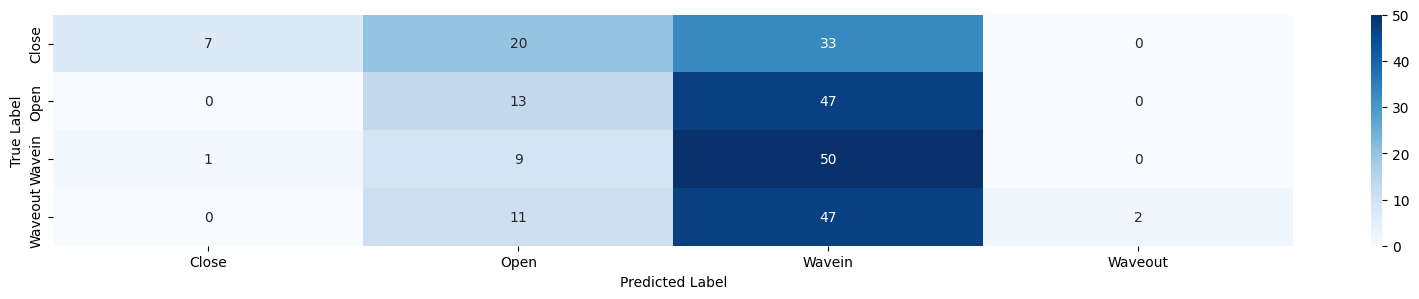

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

cm = confusion_matrix(list_label, np.argmax(model.predict(gesture), axis=-1)) 

# Create the heatmap with custom labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('True Label', fontsize = 10) # y-axis label with fontsize 15

# Show the plot
plt.show()

8/8 [==============================] - 0s 3ms/step


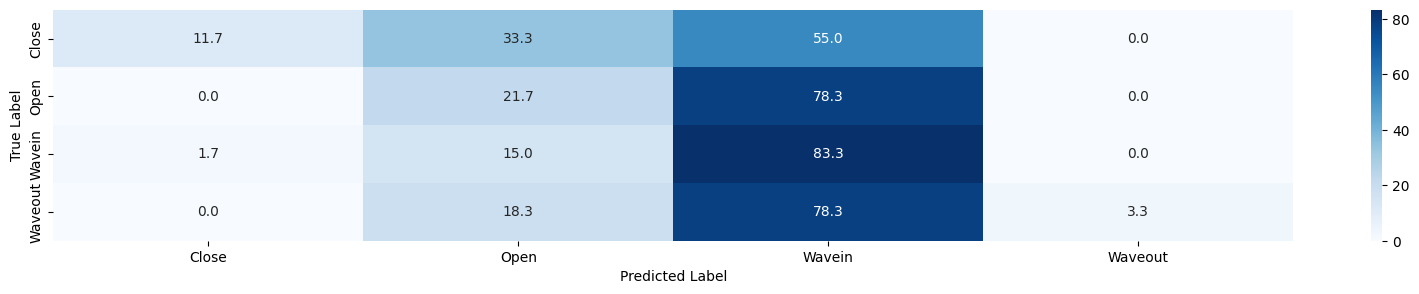

In [ ]:
cm = confusion_matrix(list_label, np.argmax(model.predict(gesture), axis=-1)) 

# Calculate the sum of predictions for each true label
sum_per_true_label = np.sum(cm, axis=1)

# Calculate the percentages
cm_percent = (cm / sum_per_true_label[:, np.newaxis]) * 100

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

# Create the heatmap with custom labels and percentage values
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# xplot = pca.fit_transform(np.vstack(gesture), X_test)
# plt.scatter(xplot[:, 0], xplot[:, 1])

In [ ]:
# # save your model
# model.save('gru_model_wo_null.h5')

### Not Rectification

(15, 480) -3.0 0.0


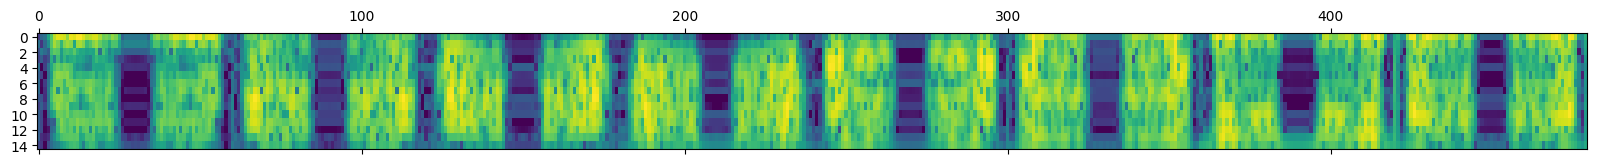

In [ ]:
fft_size = 60
step_size = fft_size - (0.80 * fft_size) # window size - (20% of window size)
thresh = 3

wav_spectrogram_1 = pretty_spectrogram(X_train_copy[0, :, 0], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_2 = pretty_spectrogram(X_train_copy[0, :, 1], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_3 = pretty_spectrogram(X_train_copy[0, :, 2], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_4 = pretty_spectrogram(X_train_copy[0, :, 3], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_5 = pretty_spectrogram(X_train_copy[0, :, 4], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_6 = pretty_spectrogram(X_train_copy[0, :, 5], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_7 = pretty_spectrogram(X_train_copy[0, :, 6], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
wav_spectrogram_8 = pretty_spectrogram(X_train_copy[0, :, 7], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)

wav_stack = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))
# wav_stack = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))
print(wav_stack.shape, wav_stack.min(),wav_stack.max())
ax=plt.axes()
ax.matshow(wav_stack)
ax.set_aspect(72/30)

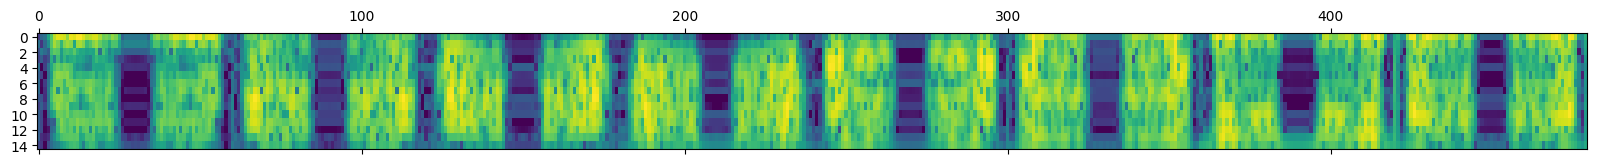

In [ ]:
X_train = X_train_copy
y_train = y_train_copy
train_data = np.zeros((X_train.shape[0], wav_stack.shape[0], wav_stack.shape[1]))
# fft_size = 80
# step_size = fft_size - (0.65 * fft_size) # window size - (20% of window size)
# thresh = 4


for i in range(X_train.shape[0]):
    # tmp = np.hstack((X_train[i, :, 0], X_train[i, :, 1], X_train[i, :, 2], X_train[i, :, 3], X_train[i, :, 4], X_train[i, :, 5], X_train[i, :, 6], X_train[i, :, 7]))
    # train_data[i,:,:] = pretty_spectrogram(tmp.flatten(), log=True, thresh=5, fft_size=200, step_size=15)
    wav_spectrogram_1 = pretty_spectrogram(X_train[i, :, 0], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_2 = pretty_spectrogram(X_train[i, :, 1], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_3 = pretty_spectrogram(X_train[i, :, 2], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_4 = pretty_spectrogram(X_train[i, :, 3], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_5 = pretty_spectrogram(X_train[i, :, 4], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_6 = pretty_spectrogram(X_train[i, :, 5], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_7 = pretty_spectrogram(X_train[i, :, 6], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)
    wav_spectrogram_8 = pretty_spectrogram(X_train[i, :, 7], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=False)

    train_data[i, :, :] = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))

ax=plt.axes()
ax.matshow(train_data[0, :, :])
ax.set_aspect(72/30)

In [ ]:
# Split into train and test sets (90% for training and 10% for testing)
X_train, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.2, random_state=42)
print(f'X_train: {np.shape(X_train)}, y_train: {np.shape(y_train)}')

X_train: (139216, 15, 480), y_train: (139216, 4)


In [ ]:
# Normalize EMG dataset
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print((X_train.shape, y_train.shape))

In [ ]:
# Split the remaining 90% into train and validation sets (50% for testing and 50% for validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(f'X_val: {np.shape(X_val)}, y_val: {np.shape(y_val)}, X_test: {np.shape(X_test)}, y_test: {np.shape(y_test)}')


X_val: (17402, 15, 480), y_val: (17402, 4), X_test: (17402, 15, 480), y_test: (17402, 4)


In [ ]:
# Normalize EMG dataset
X_val = (X_val-X_val.min())/(X_val.max()-X_val.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
print((X_test.shape, y_test.shape), (X_train.min(),X_train.max()), (X_test.min(),X_test.max()), (X_val.min(),X_val.max()))

((17402, 15, 480), (17402, 4)) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0)


In [ ]:
# # GRU + Attention
# inp = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x = GRU(128, activation='tanh', return_sequences=True)(inp)
# x = MultiHeadAttention(num_heads=32, key_dim=64)(x, x, x)
# x = GRU(64, activation='tanh', return_sequences=True)(x)
# x = MultiHeadAttention(num_heads=16, key_dim=32)(x, x, x)
# x = GRU(32, activation='tanh')(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(4, activation='softmax')(x)
# model = Model(inp, x)

# GRU
inp = Input(shape=(X_train.shape[1],X_train.shape[2]))
x = GRU(128, activation='tanh', return_sequences=True)(inp)
x = GRU(64, activation='tanh', return_sequences=True)(x)
x = GRU(32, activation='tanh')(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)
model = Model(inp, x)

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15, 480)]    0           []                               
                                                                                                  
 gru_3 (GRU)                    (None, 15, 128)      234240      ['input_2[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 15, 128)     1054848     ['gru_3[0][0]',                  
 dAttention)                                                      'gru_3[0][0]',                  
                                                                  'gru_3[0][0]']                  
                                                                                            

In [ ]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/1000
544/544 [==============================] - 17s 18ms/step - loss: 1.1726 - accuracy: 0.4356 - val_loss: 0.8943 - val_accuracy: 0.6088
Epoch 2/1000
544/544 [==============================] - 8s 15ms/step - loss: 0.8376 - accuracy: 0.6403 - val_loss: 0.7892 - val_accuracy: 0.6633
Epoch 3/1000
544/544 [==============================] - 8s 15ms/step - loss: 0.7356 - accuracy: 0.6861 - val_loss: 0.7069 - val_accuracy: 0.7000
Epoch 4/1000
544/544 [==============================] - 8s 15ms/step - loss: 0.6842 - accuracy: 0.7102 - val_loss: 0.6514 - val_accuracy: 0.7219
Epoch 5/1000
544/544 [==============================] - 8s 15ms/step - loss: 0.6473 - accuracy: 0.7263 - val_loss: 0.6324 - val_accuracy: 0.7303
Epoch 6/1000
544/544 [==============================] - 8s 15ms/step - loss: 0.6177 - accuracy: 0.7388 - val_loss: 0.6072 - val_accuracy: 0.7439
Epoch 7/1000
544/544 [==============================] - 8s 15ms/step - loss: 0.5926 - accuracy: 0.7503 - val_loss: 0.5880 - val_a

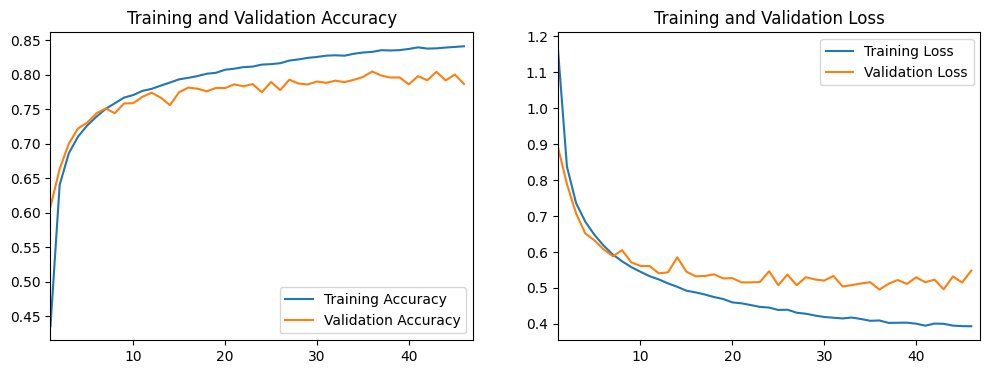

In [ ]:
# Plotting accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_acc)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=256, verbose=1)
accuracy = accuracy * 100.0
print(accuracy)

68/68 [==============================] - 1s 7ms/step - loss: 0.5058 - accuracy: 0.7990
79.90460991859436


In [ ]:
# Calculate precision, recall, and F1-score

# Convert one-hot encoded labels to original format
y_true = np.argmax(y_test, axis=1)

# Convert predicted probabilities or labels to class labels
y_pred = np.argmax(model.predict(X_test), axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the calculated metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

544/544 [==============================] - 3s 4ms/step
Precision: 0.8021854284219998
Recall: 0.7991035513159407
F1-score: 0.799638681406224


544/544 [==============================] - 2s 4ms/step


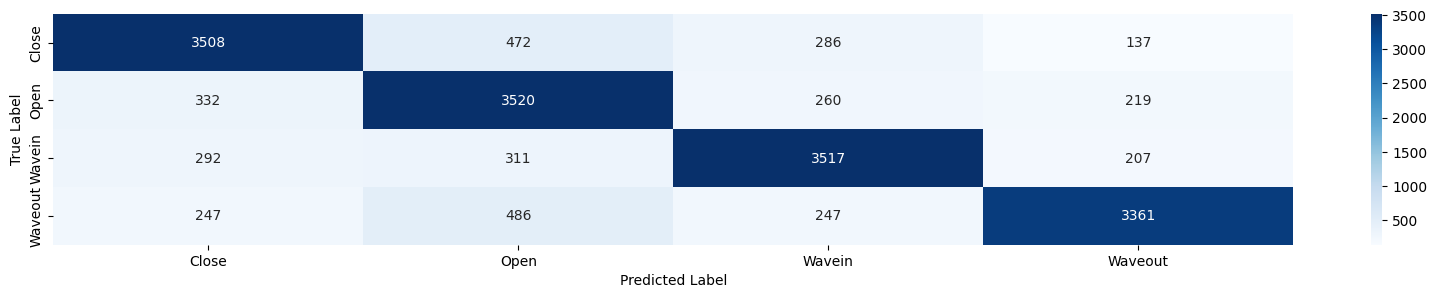

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)) 

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

# Create the heatmap with custom labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('True Label', fontsize = 10) # y-axis label with fontsize 15
# Show the plot
plt.show()

544/544 [==============================] - 2s 4ms/step


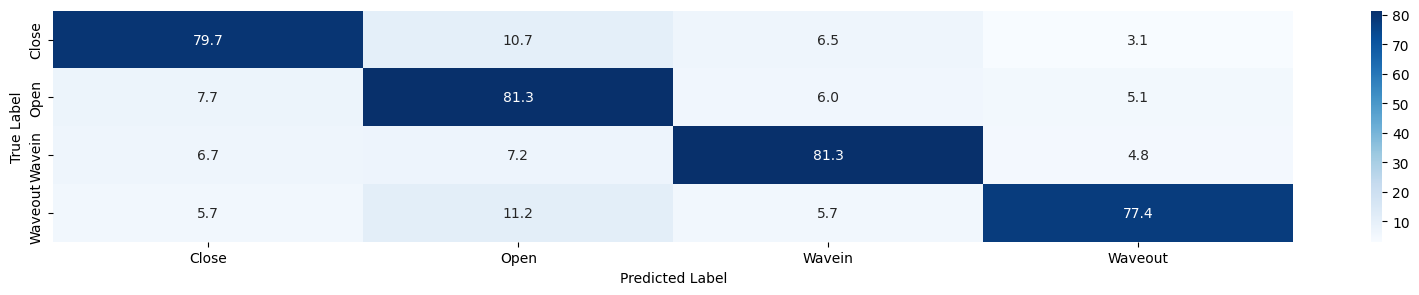

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Calculate the sum of predictions for each true label
sum_per_true_label = np.sum(cm, axis=1)

# Calculate the percentages
cm_percent = (cm / sum_per_true_label[:, np.newaxis]) * 100

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

# Create the heatmap with custom labels and percentage values
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.show()

### Test Unseen Dataset

In [ ]:
# input_data = pd.read_csv('dataset/Raw4/Test2/waveout/55.csv')
# input_data = np.array(input_data)
# ex = np.hstack((input_data[:, 0], input_data[:, 1], input_data[:, 2], input_data[:, 3], input_data[:, 4], input_data[:, 5], input_data[:, 6], input_data[:, 7]))
# plt.rcParams["figure.figsize"] = (20,3)
# plt.plot(ex)
# for n in range(0, len(ex), 200):
#     plt.axvline(x=n, color='k', linewidth=1.0, linestyle='--')

In [ ]:
path = "dataset/Raw4/Test2"
folder_dir = os.path.join(os.getcwd(), path)
dirlist = os.listdir(folder_dir)
print(dirlist)

['close', 'null', 'open', 'waveout', 'wavein']


In [ ]:
list_gesture = []
list_label = []

for gesture in dirlist:
    if("null" in gesture) or ".ipynb_checkpoints" in gesture:
        pass
    else: 
        gesture_list = os.path.join(path, gesture)
        gesture_dirlist = os.listdir(gesture_list)
        # print(gesture)
        
        true = 0
        false = 0
        for test_data in gesture_dirlist:
            # print(test_data)
            input_data = pd.read_csv(os.path.join(gesture_list, test_data))
            signal = np.array(input_data)

            if signal.shape[1] > 8:
                signal = np.array(input_data.iloc[:, 1:9])

            # Pad or Cut
            data = np.zeros((200, 8))
            if signal.shape[0] > 200:
                data[:200, :] = signal[:200, :]
            else:
                data[:signal.shape[0], :] = signal

            # Filter Signal Using High-pass Filter
            signal_filter = np.zeros((200, 8))
            nyquist_freq = 254 * 0.5            # Nyquist theorem (the sampling rate should be at least twice the highest frequency component in the signal)
            normalized_lowcut = 20 / nyquist_freq
            normalized_highcut = 100 / nyquist_freq
            b, a = sc.signal.butter(5, [normalized_lowcut, normalized_highcut], btype='bandpass', analog=False)

            for ch in range(8):
                filter = filtfilt(b, a, data[:, ch])  
                signal_filter[:, ch] = filter

            # Extract Feature
            feature = np.zeros((1, wav_stack.shape[0], wav_stack.shape[1]))
            # fft_size = 60
            # step_size = fft_size - (0.75 * fft_size) # window size - (20% of window size)
            # thresh = 3
            compute_onesided = False

            for i in range(1):
                wav_spectrogram_1 = pretty_spectrogram(signal_filter[:, 0], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_2 = pretty_spectrogram(signal_filter[:, 1], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_3 = pretty_spectrogram(signal_filter[:, 2], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_4 = pretty_spectrogram(signal_filter[:, 3], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_5 = pretty_spectrogram(signal_filter[:, 4], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_6 = pretty_spectrogram(signal_filter[:, 5], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_7 = pretty_spectrogram(signal_filter[:, 6], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                wav_spectrogram_8 = pretty_spectrogram(signal_filter[:, 7], fft_size=fft_size, step_size=step_size, log=True, thresh=thresh, compute_onesided=compute_onesided)
                
                feature[i, :, :] = np.hstack((wav_spectrogram_1, wav_spectrogram_2, wav_spectrogram_3, wav_spectrogram_4, wav_spectrogram_5, wav_spectrogram_6, wav_spectrogram_7, wav_spectrogram_8))



            # print(f'File name: {gesture} No: {test_data} Shape: {data.shape} Filter: {signal_filter.shape} Feature: {feature.shape}')
            # Normalize EMG dataset
            X = (feature-feature.min())/(feature.max()-feature.min())
            list_gesture.append(X)

            if ("close" in gesture):
                list_label.append(0)
            elif ("open" in gesture):
                list_label.append(1)
            elif ("wavein" in gesture):
                list_label.append(2)
            elif ("waveout" in gesture):
                list_label.append(3)

    gesture = np.vstack(list_gesture)
print(np.shape(gesture), np.shape(list_label))

(240, 15, 480) (240,)


8/8 [==============================] - 0s 5ms/step


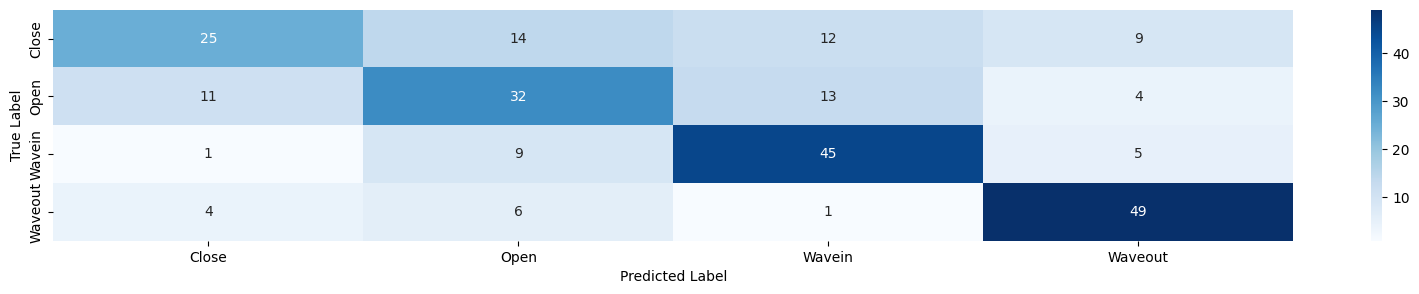

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

cm = confusion_matrix(list_label, np.argmax(model.predict(gesture), axis=-1)) 

# Create the heatmap with custom labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('True Label', fontsize = 10) # y-axis label with fontsize 15

# Show the plot
plt.show()

8/8 [==============================] - 0s 4ms/step


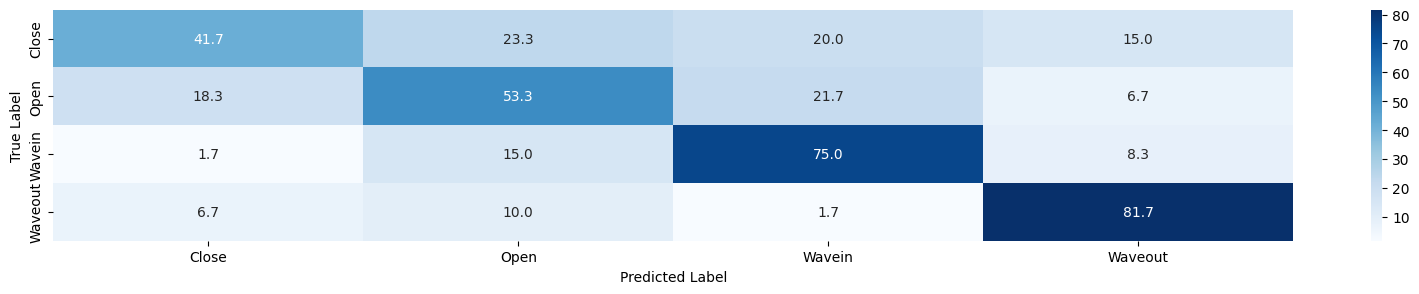

In [ ]:
cm = confusion_matrix(list_label, np.argmax(model.predict(gesture), axis=-1)) 

# Calculate the sum of predictions for each true label
sum_per_true_label = np.sum(cm, axis=1)

# Calculate the percentages
cm_percent = (cm / sum_per_true_label[:, np.newaxis]) * 100

# Define the labels for each class
class_labels = ['Close', 'Open', 'Wavein', 'Waveout']

# Create the heatmap with custom labels and percentage values
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# xplot = pca.fit_transform(np.vstack(gesture), X_test)
# plt.scatter(xplot[:, 0], xplot[:, 1])

In [ ]:
# # save your model
# model.save('gru_model_wo_null.h5')